# Cats vs Dogs классификация

In [1]:
import os, random
from pathlib import Path
import numpy as np
import tensorflow as tf

print("TF:", tf.__version__)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)
print("GPUs:", gpus)

try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy("float32")
    print("Policy:", mixed_precision.global_policy())
except Exception as e:
    print("Mixed precision not enabled:", e)


2026-01-05 06:09:46.906542: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-05 06:09:46.944664: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-05 06:09:47.834127: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/dabzelos/Desktop/cv/catdog/.venv/lib/python3.12/site-packages/keras/src/ex

TF: 2.20.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Policy: <DTypePolicy "float32">


## Пути к датасету

Ожидаем:
- `archive/images/*.png|jpg`
- `archive/annotations/*.xml`


In [2]:
ROOT = Path("archive")
IMG_DIR = ROOT / "images"
ANN_DIR = ROOT / "annotations"

assert IMG_DIR.is_dir(), f"Нет папки: {IMG_DIR}"
assert ANN_DIR.is_dir(), f"Нет папки: {ANN_DIR}"

IMG_SIZE = 224
BATCH_SIZE = 32
VAL_SPLIT = 0.2

print("IMG_DIR:", IMG_DIR)
print("ANN_DIR:", ANN_DIR)


IMG_DIR: archive/images
ANN_DIR: archive/annotations


## Парсинг XML → список примеров
Датасет из себя представляет пару - изображение + xml описание там есть тэг - собака/кошка


Особенности:
- метка берётся из `<object><name>`


In [12]:
import glob
import xml.etree.ElementTree as ET

def parse_xml(xml_path: Path):
    root = ET.parse(xml_path).getroot()
    filename = root.findtext("filename")
    objects = root.findall("object")
    if not objects:
        return None

    best = None
    best_area = -1

    for obj in objects:
        label = (obj.findtext("name") or "").strip().lower()
        if label not in ("cat", "dog"):
            continue
        bb = obj.find("bndbox")
        if bb is None:
            continue
        xmin = int(float(bb.findtext("xmin")))
        ymin = int(float(bb.findtext("ymin")))
        xmax = int(float(bb.findtext("xmax")))
        ymax = int(float(bb.findtext("ymax")))
        area = max(0, xmax - xmin) * max(0, ymax - ymin)
        if area > best_area:
            best_area = area
            best = (filename, label, xmin, ymin, xmax, ymax)

    return best

def find_image_path(filename: str) -> Path:
    p = IMG_DIR / filename
    if p.exists():
        return p
    base = Path(filename).stem
    hits = list(IMG_DIR.glob(base + ".*"))
    if hits:
        return hits[0]
    hits = list(IMG_DIR.glob("**/" + Path(filename).name))
    if hits:
        return hits[0]
    raise FileNotFoundError(f"Image not found for filename={filename}")

records = []
for x in glob.glob(str(ANN_DIR / "*.xml")):
    item = parse_xml(Path(x))
    if item is None:
        continue
    filename, label, xmin, ymin, xmax, ymax = item
    try:
        img_path = find_image_path(filename)
    except FileNotFoundError:
        continue
    y = 1 if label == "dog" else 0
    records.append((str(img_path), y, xmin, ymin, xmax, ymax))

print("Parsed records:", len(records))
if records:
    cats = sum(1 for r in records if r[1] == 0)
    dogs = sum(1 for r in records if r[1] == 1)
    print("cats:", cats, "dogs:", dogs)
    print("sample:", records[0])


Parsed records: 3686
cats: 1188 dogs: 2498
sample: ('archive/images/Cats_Test2136.png', 0, 93, 1, 297, 217)


## Train/Val split (воспроизводимо)

Делаем shuffle с `SEED`, затем берём 20% в валидацию.

Стандартное разбиение для последующей валидации модели

In [13]:
assert len(records) > 10, "Слишком мало примеров. Проверь пути/парсинг XML."

rng = np.random.default_rng(SEED)
idx = np.arange(len(records))
rng.shuffle(idx)

val_n = int(len(records) * VAL_SPLIT)
val_idx = idx[:val_n]
train_idx = idx[val_n:]

def take(idxs):
    arr = [records[i] for i in idxs]
    paths = np.array([a[0] for a in arr], dtype=np.str_)
    labels = np.array([a[1] for a in arr], dtype=np.int32)
    bboxes = np.array([[a[2], a[3], a[4], a[5]] for a in arr], dtype=np.int32)  # xmin,ymin,xmax,ymax
    return paths, labels, bboxes

train_paths, train_labels, train_bboxes = take(train_idx)
val_paths, val_labels, val_bboxes = take(val_idx)

print("Train:", len(train_paths), "Val:", len(val_paths))


Train: 2949 Val: 737


## tf.data pipeline: чтение → crop bbox → resize → preprocess

В xml файле для каждого изображения добален парамметр bbox- это границы в которых реально "полезные" части изображения(без фона и прочего) например морды собаки

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

def decode_image(path):
    img_bytes = tf.io.read_file(path)
    img = tf.io.decode_image(img_bytes, channels=3, expand_animations=False)
    img.set_shape([None, None, 3])
    return img

def crop_by_bbox(img, bbox):
    xmin, ymin, xmax, ymax = tf.unstack(tf.cast(bbox, tf.int32))
    h = tf.shape(img)[0]
    w = tf.shape(img)[1]

    xmin = tf.clip_by_value(xmin, 0, w - 1)
    xmax = tf.clip_by_value(xmax, 0, w)
    ymin = tf.clip_by_value(ymin, 0, h - 1)
    ymax = tf.clip_by_value(ymax, 0, h)

    def full():
        return img

    def cropped():
        return img[ymin:ymax, xmin:xmax, :]

    good = tf.logical_and(xmax > xmin + 1, ymax > ymin + 1)
    return tf.cond(good, cropped, full)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
], name="aug")



def preprocess(img):
    img = tf.cast(img, tf.float32) / 255.0
    return img

def make_ds(paths, labels, bboxes, training: bool):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels, bboxes))

    def _map(path, y, bb):
        img = decode_image(path)
        img = crop_by_bbox(img, bb)
        img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE), antialias=True)
        img = preprocess(img)
        y = tf.cast(y, tf.float32)
        y = tf.reshape(y, (1,))
        return img, y

    ds = ds.map(_map, num_parallel_calls=AUTOTUNE)
    ds = ds.cache("cache_train" if training else "cache_val")

    if training:
        ds = ds.shuffle(2000, seed=SEED, reshuffle_each_iteration=True)

    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    ds = ds.apply(tf.data.experimental.ignore_errors())
    return ds


train_ds = make_ds(train_paths, train_labels, train_bboxes, training=True)
val_ds = make_ds(val_paths, val_labels, val_bboxes, training=False)

for x, y in train_ds.take(1):
    print("batch x:", x.shape, "y:", y.shape, "y[:5]:", y[:5].numpy().reshape(-1))


batch x: (32, 224, 224, 3) y: (32, 1) y[:5]: [1. 1. 1. 0. 1.]


2026-01-05 06:25:59.560719: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Визуальная проверка кропов

2026-01-05 06:10:19.314146: W tensorflow/core/kernels/data/cache_dataset_ops.cc:333] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


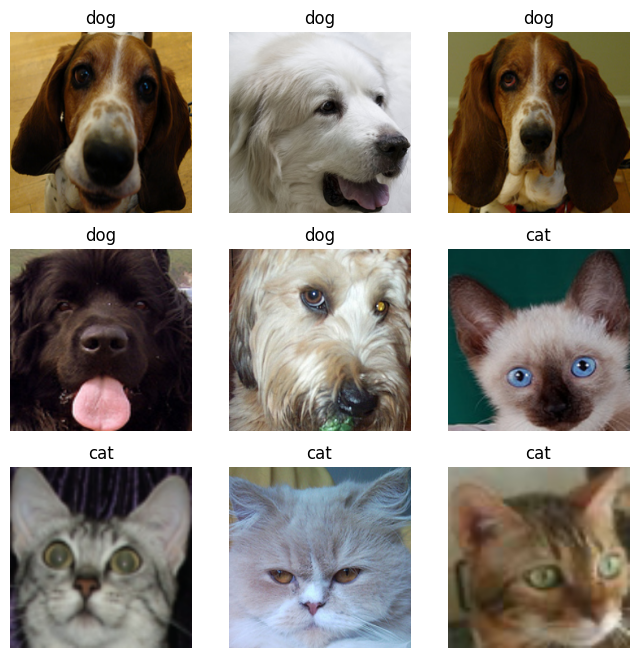

2026-01-05 06:10:19.779232: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
import matplotlib.pyplot as plt

def show_batch(ds, n=9):
    for xb, yb in ds.take(1):
        xb = xb.numpy()
        yb = yb.numpy().reshape(-1)
        plt.figure(figsize=(8,8))
        for i in range(min(n, xb.shape[0])):
            ax = plt.subplot(3,3,i+1)
            vis = xb[i] * 255.0
            vis = np.clip(vis, 0, 255).astype("uint8")
            plt.imshow(vis)
            plt.title("dog" if yb[i] > 0.5 else "cat")
            plt.axis("off")
        plt.show()

show_batch(train_ds)


## Обучение( создание модели)

In [ ]:
from tensorflow.keras import layers, models, Input


data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
], name="aug")

model = models.Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    data_augmentation,

    # block 1
    layers.Conv2D(32, 3, padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    # block 2
    layers.Conv2D(64, 3, padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    # block 3
    layers.Conv2D(128, 3, padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    # block 4
    layers.Conv2D(256, 3, padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.35),
    layers.Dense(1, activation="sigmoid", dtype="float32"),
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ aug (Sequential)                │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 390,113 (1.49 MB)

 Trainable params: 389,153 (1.48 MB)

 Non-trainable params: 960 (3.75 KB)

## Обучение

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ],
)

callbacks = [
    ModelCheckpoint("best_bbox.keras", monitor="val_auc", mode="max", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_auc", mode="max", patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=2, min_lr=1e-6, verbose=1),
]

history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks,
)


Epoch 1/15


2026-01-05 06:10:38.759617: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701


     29/Unknown 12s 146ms/step - accuracy: 0.6265 - auc: 0.5457 - loss: 0.7818 - precision: 0.6903 - recall: 0.8126

2026-01-05 06:10:46.112072: W tensorflow/core/kernels/data/cache_dataset_ops.cc:333] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


     93/Unknown 22s 151ms/step - accuracy: 0.6330 - auc: 0.5570 - loss: 0.7196 - precision: 0.6883 - recall: 0.8348

2026-01-05 06:10:56.061082: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2026-01-05 06:10:56.061107: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10846479485014897225
2026-01-05 06:10:56.061112: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17183024213411228152
2026-01-05 06:10:56.061115: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4690245570011894326
/home/dabzelos/Desktop/cv/catdog/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your datas


Epoch 1: val_auc improved from None to 0.48401, saving model to best_bbox.keras

Epoch 1: finished saving model to best_bbox.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 179ms/step - accuracy: 0.6524 - auc: 0.5832 - loss: 0.6667 - precision: 0.6937 - recall: 0.8660 - val_accuracy: 0.6961 - val_auc: 0.4840 - val_loss: 0.6678 - val_precision: 0.6961 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/15


2026-01-05 06:10:58.489277: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1768015327109540119
2026-01-05 06:10:58.489296: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6166979208259799088
2026-01-05 06:10:58.489299: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6016494888005840712


92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.6833 - auc: 0.6827 - loss: 0.6029 - precision: 0.7193 - recall: 0.8517

2026-01-05 06:11:13.378052: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2026-01-05 06:11:13.378074: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10846479485014897225
2026-01-05 06:11:13.378079: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17183024213411228152
2026-01-05 06:11:13.378081: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4690245570011894326



Epoch 2: val_auc improved from 0.48401 to 0.54645, saving model to best_bbox.keras

Epoch 2: finished saving model to best_bbox.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 0.6945 - auc: 0.6843 - loss: 0.5949 - precision: 0.7302 - recall: 0.8660 - val_accuracy: 0.3039 - val_auc: 0.5465 - val_loss: 0.9470 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/15


2026-01-05 06:11:14.055450: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6016494888005840712


92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.7157 - auc: 0.7070 - loss: 0.5685 - precision: 0.7538 - recall: 0.8724

2026-01-05 06:11:28.168796: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10846479485014897225
2026-01-05 06:11:28.168818: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17183024213411228152
2026-01-05 06:11:28.168822: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4690245570011894326



Epoch 3: val_auc improved from 0.54645 to 0.66255, saving model to best_bbox.keras

Epoch 3: finished saving model to best_bbox.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - accuracy: 0.7172 - auc: 0.7231 - loss: 0.5683 - precision: 0.7503 - recall: 0.8690 - val_accuracy: 0.6961 - val_auc: 0.6625 - val_loss: 0.5909 - val_precision: 0.6961 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/15


2026-01-05 06:11:28.828071: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1768015327109540119
2026-01-05 06:11:28.828091: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6166979208259799088
2026-01-05 06:11:28.828094: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6016494888005840712


92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.7277 - auc: 0.7449 - loss: 0.5572 - precision: 0.7580 - recall: 0.8691

2026-01-05 06:11:43.080075: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2026-01-05 06:11:43.080106: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10846479485014897225
2026-01-05 06:11:43.080113: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17183024213411228152
2026-01-05 06:11:43.080117: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4690245570011894326



Epoch 4: val_auc improved from 0.66255 to 0.74133, saving model to best_bbox.keras

Epoch 4: finished saving model to best_bbox.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.7345 - auc: 0.7600 - loss: 0.5408 - precision: 0.7662 - recall: 0.8715 - val_accuracy: 0.7137 - val_auc: 0.7413 - val_loss: 0.5786 - val_precision: 0.7915 - val_recall: 0.7992 - learning_rate: 0.0010
Epoch 5/15


2026-01-05 06:11:43.747393: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1768015327109540119
2026-01-05 06:11:43.747415: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6166979208259799088
2026-01-05 06:11:43.747425: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6016494888005840712


92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.7424 - auc: 0.7776 - loss: 0.5229 - precision: 0.7709 - recall: 0.8810

2026-01-05 06:11:58.075057: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10846479485014897225
2026-01-05 06:11:58.075087: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17183024213411228152
2026-01-05 06:11:58.075090: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4690245570011894326



Epoch 5: val_auc improved from 0.74133 to 0.80473, saving model to best_bbox.keras

Epoch 5: finished saving model to best_bbox.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 156ms/step - accuracy: 0.7535 - auc: 0.7893 - loss: 0.5128 - precision: 0.7786 - recall: 0.8856 - val_accuracy: 0.7300 - val_auc: 0.8047 - val_loss: 0.5232 - val_precision: 0.7256 - val_recall: 0.9844 - learning_rate: 0.0010
Epoch 6/15
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.7761 - auc: 0.8221 - loss: 0.4666 - precision: 0.8135 - recall: 0.8832

2026-01-05 06:12:13.128115: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10846479485014897225
2026-01-05 06:12:13.128137: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17183024213411228152
2026-01-05 06:12:13.128141: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4690245570011894326



Epoch 6: val_auc did not improve from 0.80473
93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.7691 - auc: 0.8262 - loss: 0.4711 - precision: 0.7980 - recall: 0.8796 - val_accuracy: 0.7178 - val_auc: 0.7802 - val_loss: 0.5635 - val_precision: 0.7259 - val_recall: 0.9552 - learning_rate: 0.0010
Epoch 7/15


2026-01-05 06:12:13.804368: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1768015327109540119
2026-01-05 06:12:13.804399: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6166979208259799088
2026-01-05 06:12:13.804402: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6016494888005840712


92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8024 - auc: 0.8500 - loss: 0.4499 - precision: 0.8236 - recall: 0.9007

2026-01-05 06:12:28.007805: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10846479485014897225
2026-01-05 06:12:28.007827: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17183024213411228152
2026-01-05 06:12:28.007830: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4690245570011894326



Epoch 7: val_auc did not improve from 0.80473

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.7976 - auc: 0.8499 - loss: 0.4445 - precision: 0.8166 - recall: 0.9018 - val_accuracy: 0.3297 - val_auc: 0.6954 - val_loss: 2.9919 - val_precision: 1.0000 - val_recall: 0.0370 - learning_rate: 0.0010
Epoch 8/15


2026-01-05 06:12:28.678455: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1768015327109540119
2026-01-05 06:12:28.678476: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6166979208259799088
2026-01-05 06:12:28.678479: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6016494888005840712


92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8002 - auc: 0.8445 - loss: 0.4430 - precision: 0.8314 - recall: 0.8860

2026-01-05 06:12:42.862127: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2026-01-05 06:12:42.862153: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10846479485014897225
2026-01-05 06:12:42.862160: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17183024213411228152
2026-01-05 06:12:42.862182: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4690245570011894326



Epoch 8: val_auc improved from 0.80473 to 0.86449, saving model to best_bbox.keras

Epoch 8: finished saving model to best_bbox.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.8037 - auc: 0.8652 - loss: 0.4236 - precision: 0.8270 - recall: 0.8957 - val_accuracy: 0.7680 - val_auc: 0.8645 - val_loss: 0.4653 - val_precision: 0.8904 - val_recall: 0.7602 - learning_rate: 5.0000e-04
Epoch 9/15


2026-01-05 06:12:43.523372: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1768015327109540119
2026-01-05 06:12:43.523397: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6166979208259799088
2026-01-05 06:12:43.523407: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6016494888005840712


92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8005 - auc: 0.8616 - loss: 0.4256 - precision: 0.8314 - recall: 0.8858

2026-01-05 06:12:57.738913: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10846479485014897225
2026-01-05 06:12:57.738940: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17183024213411228152
2026-01-05 06:12:57.738943: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4690245570011894326



Epoch 9: val_auc did not improve from 0.86449
93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - accuracy: 0.8169 - auc: 0.8854 - loss: 0.3926 - precision: 0.8381 - recall: 0.9023 - val_accuracy: 0.5984 - val_auc: 0.8345 - val_loss: 0.9749 - val_precision: 0.9540 - val_recall: 0.4444 - learning_rate: 5.0000e-04
Epoch 10/15


2026-01-05 06:12:58.401216: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1768015327109540119
2026-01-05 06:12:58.401236: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6166979208259799088
2026-01-05 06:12:58.401239: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6016494888005840712


92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8445 - auc: 0.9033 - loss: 0.3661 - precision: 0.8650 - recall: 0.9105

2026-01-05 06:13:12.532021: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10846479485014897225
2026-01-05 06:13:12.532043: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17183024213411228152
2026-01-05 06:13:12.532046: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4690245570011894326



Epoch 10: val_auc improved from 0.86449 to 0.90076, saving model to best_bbox.keras

Epoch 10: finished saving model to best_bbox.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.8311 - auc: 0.8949 - loss: 0.3764 - precision: 0.8529 - recall: 0.9053 - val_accuracy: 0.8128 - val_auc: 0.9008 - val_loss: 0.4048 - val_precision: 0.9103 - val_recall: 0.8109 - learning_rate: 5.0000e-04
Epoch 11/15


2026-01-05 06:13:13.203859: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1768015327109540119
2026-01-05 06:13:13.203881: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6166979208259799088
2026-01-05 06:13:13.203884: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6016494888005840712


92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8544 - auc: 0.9046 - loss: 0.3624 - precision: 0.8640 - recall: 0.9286

2026-01-05 06:13:27.426209: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10846479485014897225
2026-01-05 06:13:27.426230: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17183024213411228152
2026-01-05 06:13:27.426234: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4690245570011894326



Epoch 11: val_auc did not improve from 0.90076
93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.8477 - auc: 0.9079 - loss: 0.3571 - precision: 0.8661 - recall: 0.9154 - val_accuracy: 0.7422 - val_auc: 0.8879 - val_loss: 0.5733 - val_precision: 0.9425 - val_recall: 0.6706 - learning_rate: 5.0000e-04
Epoch 12/15


2026-01-05 06:13:28.096744: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1768015327109540119
2026-01-05 06:13:28.096765: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6166979208259799088
2026-01-05 06:13:28.096776: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6016494888005840712


92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8497 - auc: 0.9188 - loss: 0.3362 - precision: 0.8665 - recall: 0.9154

2026-01-05 06:13:42.257967: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10846479485014897225
2026-01-05 06:13:42.257989: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17183024213411228152
2026-01-05 06:13:42.257991: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4690245570011894326



Epoch 12: val_auc did not improve from 0.90076

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - accuracy: 0.8471 - auc: 0.9191 - loss: 0.3361 - precision: 0.8680 - recall: 0.9113 - val_accuracy: 0.6730 - val_auc: 0.8963 - val_loss: 0.7080 - val_precision: 0.9533 - val_recall: 0.5575 - learning_rate: 5.0000e-04
Epoch 13/15


2026-01-05 06:13:42.917402: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1768015327109540119
2026-01-05 06:13:42.917435: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6166979208259799088
2026-01-05 06:13:42.917439: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6016494888005840712


92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8608 - auc: 0.9282 - loss: 0.3230 - precision: 0.8764 - recall: 0.9204

2026-01-05 06:13:57.063816: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10846479485014897225
2026-01-05 06:13:57.063837: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17183024213411228152
2026-01-05 06:13:57.063840: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4690245570011894326



Epoch 13: val_auc improved from 0.90076 to 0.94474, saving model to best_bbox.keras

Epoch 13: finished saving model to best_bbox.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.8691 - auc: 0.9308 - loss: 0.3145 - precision: 0.8831 - recall: 0.9285 - val_accuracy: 0.8697 - val_auc: 0.9447 - val_loss: 0.2950 - val_precision: 0.8614 - val_recall: 0.9688 - learning_rate: 2.5000e-04
Epoch 14/15


2026-01-05 06:13:57.729313: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1768015327109540119
2026-01-05 06:13:57.729333: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6166979208259799088
2026-01-05 06:13:57.729336: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6016494888005840712


92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8690 - auc: 0.9350 - loss: 0.3052 - precision: 0.8786 - recall: 0.9353

2026-01-05 06:14:11.917874: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10846479485014897225
2026-01-05 06:14:11.917897: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17183024213411228152
2026-01-05 06:14:11.917900: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4690245570011894326



Epoch 14: val_auc improved from 0.94474 to 0.95789, saving model to best_bbox.keras

Epoch 14: finished saving model to best_bbox.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.8715 - auc: 0.9375 - loss: 0.3008 - precision: 0.8827 - recall: 0.9330 - val_accuracy: 0.9023 - val_auc: 0.9579 - val_loss: 0.2619 - val_precision: 0.9002 - val_recall: 0.9669 - learning_rate: 2.5000e-04
Epoch 15/15
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8967 - auc: 0.9501 - loss: 0.2696 - precision: 0.9097 - recall: 0.9437

2026-01-05 06:14:26.825613: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10846479485014897225
2026-01-05 06:14:26.825633: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 8048390144321369483
2026-01-05 06:14:26.825639: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17183024213411228152
2026-01-05 06:14:26.825643: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4690245570011894326
2026-01-05 06:14:26.825645: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 15626183653229833700



Epoch 15: val_auc did not improve from 0.95789
93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - accuracy: 0.8830 - auc: 0.9446 - loss: 0.2825 - precision: 0.8939 - recall: 0.9375 - val_accuracy: 0.8548 - val_auc: 0.9358 - val_loss: 0.3431 - val_precision: 0.9452 - val_recall: 0.8402 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 14.


2026-01-05 06:14:27.485328: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1768015327109540119
2026-01-05 06:14:27.485349: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6166979208259799088
2026-01-05 06:14:27.485351: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6016494888005840712


## Оценка

In [11]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

y_true, y_pred = [], []

for xb, yb in val_ds:
    p = model.predict(xb, verbose=0).reshape(-1)
    y_true.extend(yb.numpy().reshape(-1).astype(int).tolist())
    y_pred.extend((p > 0.5).astype(int).tolist())

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)
print()
print(classification_report(y_true, y_pred, target_names=["cat","dog"]))


Confusion matrix:
 [[169  55]
 [ 17 496]]

              precision    recall  f1-score   support

         cat       0.91      0.75      0.82       224
         dog       0.90      0.97      0.93       513

    accuracy                           0.90       737
   macro avg       0.90      0.86      0.88       737
weighted avg       0.90      0.90      0.90       737



Выше видны результаты работы модели 
Точность в районе 90%